In [234]:
from google.colab import drive
import pandas as pd

In [235]:
DIR = 'drive/MyDrive/CS/WGU/Computer Science Capstone - C964/vlm-image-to-description-generator'

In [237]:
drive.mount('/content/drive')

%cd "$DIR"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/CS/WGU/Computer Science Capstone - C964/vlm-image-to-description-generator'
/content/drive/MyDrive/CS/WGU/Computer Science Capstone - C964/vlm-image-to-description-generator


In [4]:
import json

# Read in both the model and the baseline descriptions

In [111]:
with open("aypt2025-13_data_descriptions.json", "r") as f:
  model_df = (
    pd.DataFrame(json.load(f))
    .T                              # transpose to get items as rows
    .rename_axis("item_number")     # turn index into the item numbers
    .reset_index()                  # move item_number into a column
    .assign(item_number=lambda d: pd.to_numeric(d["item_number"])) # Make item number of type int
    .sort_values("item_number") # sort by item number
    .reset_index(drop=True)
    .rename(columns={"description": "model_desc"})
  )

In [112]:
model_df.head()

,item_number,text,labels,objects,thumbnail_path,model_desc
0,1,"[impact, impact, FLEXIBLE TO, FLEXIBLE, TO, im...","[Tripod, Bag, Baggage, Cameras & optics, Optic...",[],aypt2025-13/1_1.jpg,Professional photography equipment set featuri...
1,2,"[INTERIIT, INTERIIT, INTERFIT, INTERFIT, INTER...","[Electronic device, Microphone stand, Electric...",[Tripod],aypt2025-13/2_1.jpg,"Electronic device with ""INTERFIT"" branding, mo..."
2,3,"[INTERFIT\nStellar, INTERFIT, Stellar, INTERFI...","[Electronic device, Cameras & optics, Electric...","[Lighting, Tripod]",aypt2025-13/3_1.jpg,Professional-grade grey overhead projector wit...
3,4,"[INTERFIT\nStellar, INTERFIT, Stellar, INTERFI...","[Electronic device, Electrical cable, Cameras ...","[Tripod, Lighting]",aypt2025-13/4_1.jpg,"Electronic device, INTERFIT Stellar 300, small..."
4,5,"[INTERFIT, INTERFIT, INTERFIT, INTERFIT, INTER...",[Balance],[Hat],aypt2025-13/5_1.jpg,"Round black hat with ""INTERFIT"" printed in whi..."


In [250]:
model_df[model_df['model_desc'].str.contains('model')]

,item_number,text,labels,objects,thumbnail_path,model_desc
2,3,"[INTERFIT\nStellar, INTERFIT, Stellar, INTERFI...","[Electronic device, Cameras & optics, Electric...","[Lighting, Tripod]",aypt2025-13/3_1.jpg,Professional-grade grey overhead projector wit...
37,38,"[23456-7 8 9 10 11\n22\n3\n56\n16418, 23456-7,...","[Sailing ship, Boat, Watercraft, Mast, Ship re...",[],aypt2025-13/38_1.jpg,"Antique-style, full-rigged, golden-hulled ship..."
50,51,"[ADELTA &\nシル, ADELTA, &, シル, 34\n5\n6-78 910\...","[Machine, Silver, Electrical cable, Wire]",[],aypt2025-13/51_1.jpg,Vintage Delta Industrial Machinery Corp. SAWBU...
55,56,"[(H) Husqvarna\nHusqvama, (, H, ), Husqvarna, ...","[Chainsaw, Saw, Power tool, Machine, Tool, Out...",[Chainsaw],aypt2025-13/56_1.jpg,"Husqvarna chainsaw, orange with gray handles, ..."
56,57,"[口\nGIHAND, 口, GIHAND, H\n2037\nLIONEL\nLINES\...","[Track, Steel, Train, Rail transport, Rolling ...",[],aypt2025-13/57_1.jpg,"Vintage Lionel train track set, featuring a va..."


In [245]:
model_df[model_df['item_number']==44]['model_desc'].iloc[0]

'Antique-style rug with intricate gold and black floral patterns on a beige background. Features a detailed central motif and ornate borders. Made from pure wool, perfect for adding elegance to any living space. Measures 4\'6" x 6\'.'

In [116]:
baseline_df = (
  pd.read_csv("Aypt2025-13 - Sheet1.csv")
  .rename(columns={"ItemNumber": "item_number", "Description": "baseline_desc"})
  .assign(item_number=lambda d: d["item_number"].astype(int))
)

baseline_df = baseline_df[['AuctionName', 'item_number', baseline_desc]]

In [117]:
baseline_df.head()

,AuctionName,item_number,baseline_desc
0,Aypt2025-13,1,Impact-branded photo backdrop kit including a ...
1,Aypt2025-13,2,Interfit Stellar X flash lighting unit with ad...
2,Aypt2025-13,3,Interfit Stellar X 300 studio strobe light wit...
3,Aypt2025-13,4,Interfit Stellar X 300 studio flash unit equip...
4,Aypt2025-13,5,Interfit COR 751 lighting kit with a wheeled c...


In [118]:
both_descriptions = (
  baseline_df[["item_number", "baseline_desc"]]
  .merge(model_df[["item_number", "model_desc"]], on="item_number", how="left")
)
both_descriptions.head()

,item_number,baseline_desc,model_desc
0,1,Impact-branded photo backdrop kit including a ...,Professional photography equipment set featuri...
1,2,Interfit Stellar X flash lighting unit with ad...,"Electronic device with ""INTERFIT"" branding, mo..."
2,3,Interfit Stellar X 300 studio strobe light wit...,Professional-grade grey overhead projector wit...
3,4,Interfit Stellar X 300 studio flash unit equip...,"Electronic device, INTERFIT Stellar 300, small..."
4,5,Interfit COR 751 lighting kit with a wheeled c...,"Round black hat with ""INTERFIT"" printed in whi..."


# Randomize the order of the model/baseline descriptions and keep track of the source

In [120]:
import random

def randomize(row):
  # Each option: (column_name, description_text, source_label)
  options = [
    (row["model_desc"], "model"),
    (row["baseline_desc"], "baseline")
  ]
  random.shuffle(options)

  return pd.Series({
    "item_number": row["item_number"],
    "desc1": options[0][0],
    "desc1_source": options[0][1],
    "desc2": options[1][0],
    "desc2_source": options[1][1]
  })

In [149]:
test = both_descriptions.apply(randomize, axis=1)
test.head()

,item_number,desc1,desc1_source,desc2,desc2_source
0,1,Impact-branded photo backdrop kit including a ...,baseline,Professional photography equipment set featuri...,model
1,2,Interfit Stellar X flash lighting unit with ad...,baseline,"Electronic device with ""INTERFIT"" branding, mo...",model
2,3,Interfit Stellar X 300 studio strobe light wit...,baseline,Professional-grade grey overhead projector wit...,model
3,4,Interfit Stellar X 300 studio flash unit equip...,baseline,"Electronic device, INTERFIT Stellar 300, small...",model
4,5,Interfit COR 751 lighting kit with a wheeled c...,baseline,"Round black hat with ""INTERFIT"" printed in whi...",model


In [196]:
import textwrap
from IPython.display import clear_output
from time import sleep

In [150]:
wrap_width = 80

def human_evaluation(row):
  print(f'Item number {row['item_number']}:')
  print("Description 1:")
  print(textwrap.fill(row["desc1"], width=wrap_width))
  print()

  print("Description 2:")
  print(textwrap.fill(row["desc2"], width=wrap_width))
  print()

  print("\nChoices:")
  print("1 = Description 1 better")
  print("2 = Description 2 better")
  print("3 = Both good")
  print("4 = Both bad")

  while True:
    choice = input("Your choice: ")
    if choice in {"1", "2", "3", "4"}:
      return int(choice)

In [151]:
def get_start_point(max_item = 60):
  while True:
    start_point = input(
      f"Choose an item number to start at (1 to {max_item}): "
    )

    # Handle non-integers gracefully
    if not start_point.isdigit():
      print("❌ Invalid input. Please enter a number.")
      continue

    start_point = int(start_point)

    # Check range
    if 1 <= start_point <= max_item:
      return start_point
    else:
      print(f"❌ Number out of range. Please choose between 1 and {max_item}.")

In [199]:
def evaluate_descriptions(df, max_items = 60):
  start_point = get_start_point()

  for item in range(start_point, max_items + 1):
    row = df[df['item_number'] == item].iloc[0]
    choice = human_evaluation(row)
    match choice:
      case 1:
        human_eval = row['desc1_source']
      case 2:
        human_eval = row['desc2_source']
      case 3:
        human_eval = 'Both descriptions are acceptable'
      case 4:
        human_eval = 'Both descriptions are unnacceptable'
      case _:
        human_eval = f'Error recording response for item {item}'

    df.loc[df['item_number'] == item, 'human_label'] = human_eval

    clear_output(wait=False)
    sleep(0.5)

  print(f'✅ Finished evaluating items')

In [233]:
evaluate_descriptions(test)

Item number 45:
Description 1:
Antique ornate rug with intricate floral and vine motifs in green, yellow, and
beige on a cream background. Fringed edges, 5x8 feet. Handwoven in India, made
from 100% wool. Ideal for vintage decor.

Description 2:
Handwoven wool rug from the Soumak Collection, Mahal 675 design, in a soft ivory
field with intricate botanical motifs in muted greens, golds, and rust tones.
Finished with fringe edges. Measures approximately 4 feet by 8 feet.


Choices:
1 = Description 1 better
2 = Description 2 better
3 = Both good
4 = Both bad


KeyboardInterrupt: Interrupted by user

In [225]:
test

,item_number,desc1,desc1_source,desc2,desc2_source,human_label
0,1,Impact-branded photo backdrop kit including a ...,baseline,Professional photography equipment set featuri...,model,Both descriptions are acceptable
1,2,Interfit Stellar X flash lighting unit with ad...,baseline,"Electronic device with ""INTERFIT"" branding, mo...",model,baseline
2,3,Interfit Stellar X 300 studio strobe light wit...,baseline,Professional-grade grey overhead projector wit...,model,baseline
3,4,Interfit Stellar X 300 studio flash unit equip...,baseline,"Electronic device, INTERFIT Stellar 300, small...",model,baseline
4,5,Interfit COR 751 lighting kit with a wheeled c...,baseline,"Round black hat with ""INTERFIT"" printed in whi...",model,baseline
5,6,Pair of Impact floodlight fixtures mounted on ...,baseline,Professional studio lighting kit featuring two...,model,Both descriptions are acceptable
6,7,Assorted hand tool collection including Sears ...,baseline,"Forged metalworking hand tools set, including ...",model,baseline
7,8,Vintage set of metalworking tools and househol...,model,Box of assorted hand tools including multiple ...,baseline,baseline
8,9,"Clear plastic storage box containing a 4-1/2"" ...",model,Clear storage bin filled with grinding and cut...,baseline,Both descriptions are acceptable
9,10,"Heavy-duty Armstrong slide hammer puller set, ...",baseline,"Vintage metal tool with a wrapped, blue and wh...",model,baseline


In [227]:
test.to_csv('Aypt2025-13_evaluated.csv', index=False)

In [229]:
test

,item_number,desc1,desc1_source,desc2,desc2_source,human_label
0,1,Impact-branded photo backdrop kit including a ...,baseline,Professional photography equipment set featuri...,model,Both descriptions are acceptable
1,2,Interfit Stellar X flash lighting unit with ad...,baseline,"Electronic device with ""INTERFIT"" branding, mo...",model,baseline
2,3,Interfit Stellar X 300 studio strobe light wit...,baseline,Professional-grade grey overhead projector wit...,model,baseline
3,4,Interfit Stellar X 300 studio flash unit equip...,baseline,"Electronic device, INTERFIT Stellar 300, small...",model,baseline
4,5,Interfit COR 751 lighting kit with a wheeled c...,baseline,"Round black hat with ""INTERFIT"" printed in whi...",model,baseline
5,6,Pair of Impact floodlight fixtures mounted on ...,baseline,Professional studio lighting kit featuring two...,model,Both descriptions are acceptable
6,7,Assorted hand tool collection including Sears ...,baseline,"Forged metalworking hand tools set, including ...",model,baseline
7,8,Vintage set of metalworking tools and househol...,model,Box of assorted hand tools including multiple ...,baseline,baseline
8,9,"Clear plastic storage box containing a 4-1/2"" ...",model,Clear storage bin filled with grinding and cut...,baseline,Both descriptions are acceptable
9,10,"Heavy-duty Armstrong slide hammer puller set, ...",baseline,"Vintage metal tool with a wrapped, blue and wh...",model,baseline


In [230]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='count', ylabel='human_label'>

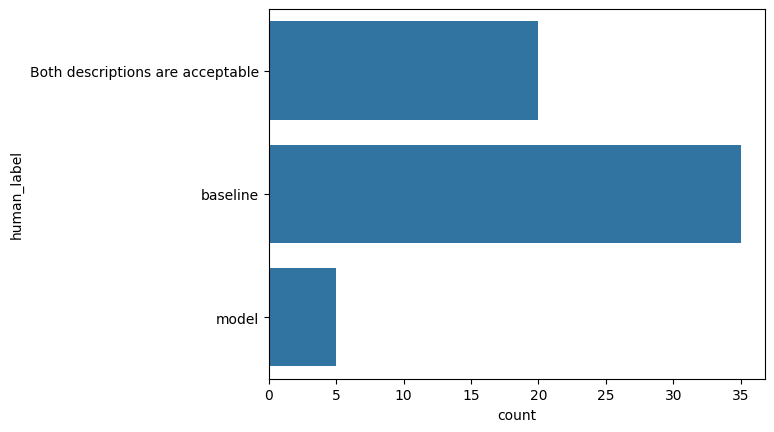

In [232]:
sns.countplot(test['human_label'])